# 데이터 불러오고 파일 만들기

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import colorsys
import os
from matplotlib.patches import Polygon

파일 이름 설명

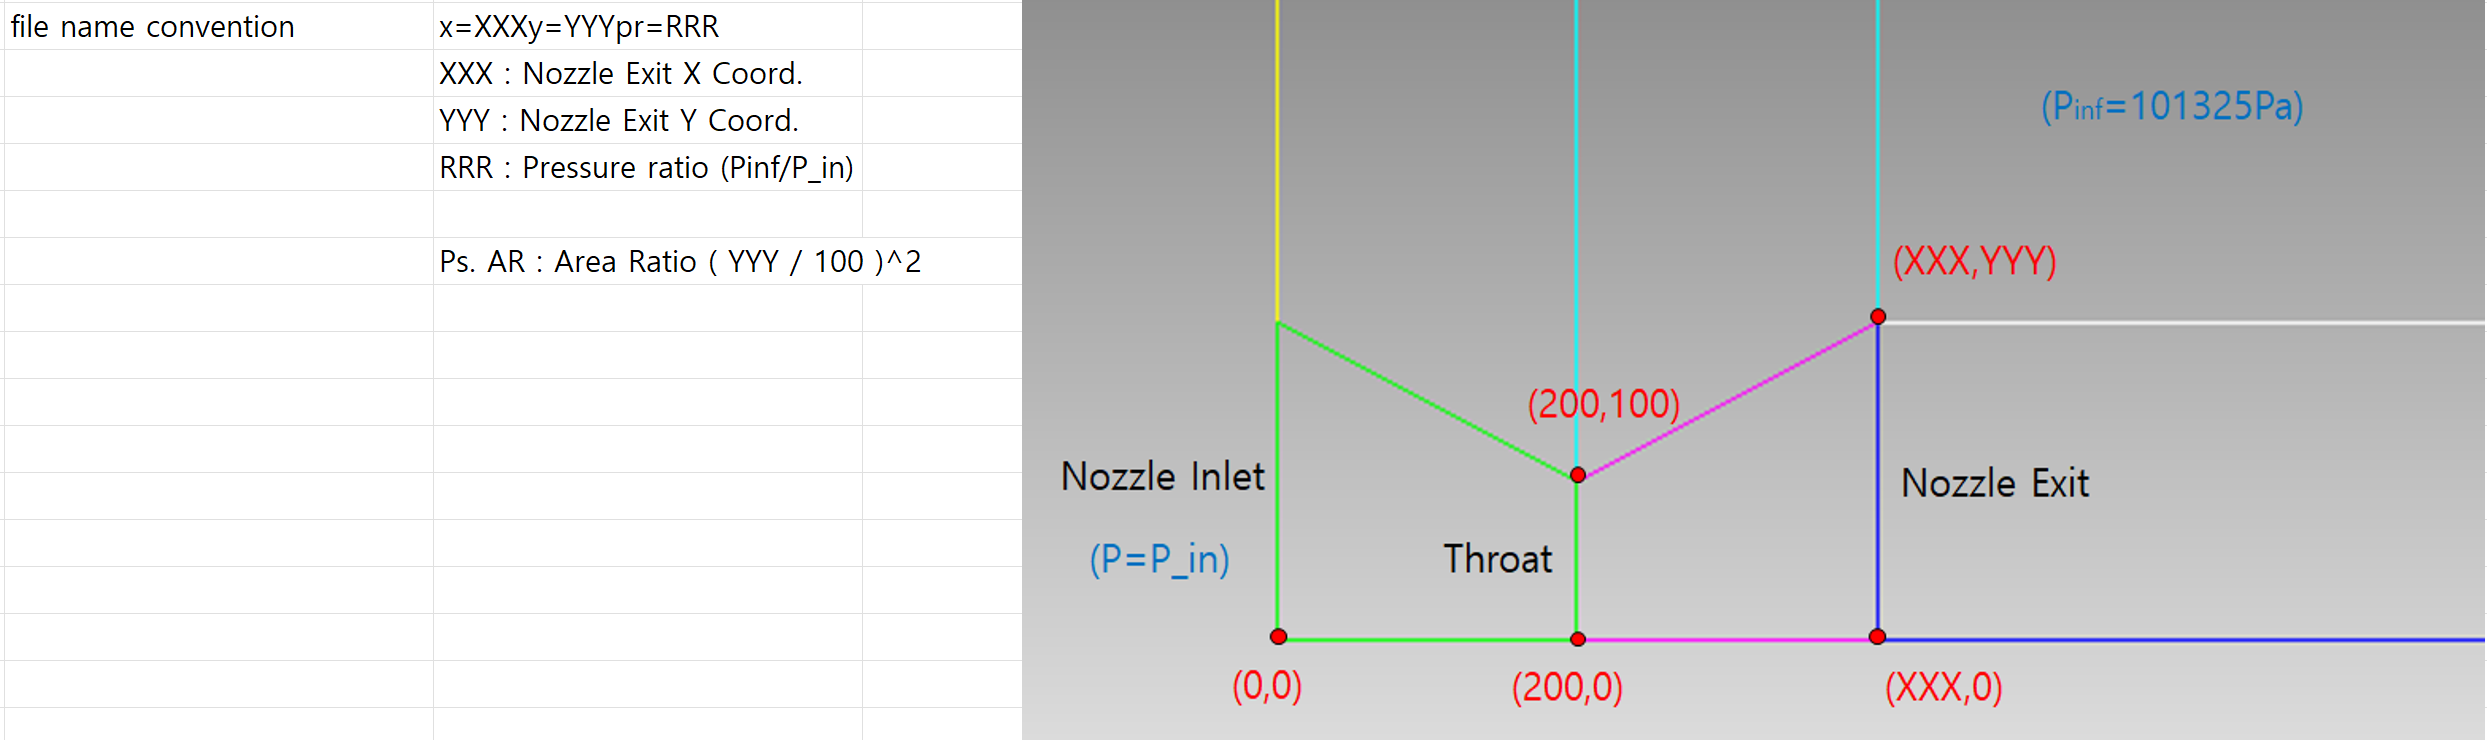

그림출처파일: `20210730/pr_grad_rev2.xlsx`



## (구버전) 학습용 메시 데이터를 .csv 파일로 변환하고 통합하는 코드

- 다음 코드는 Cell의 위치를 정렬하지 않음
- 다음 코드는 (노즐 내부/외부 등의) 바이너리 정보를 포함하지 않음
- 노즐 5각형에 대한 MVC 특징은 나중에 실제 사용할 때 제거할 것을 추천. 과거 코드이므로 남겨둠

In [2]:
def color(deg):
    return colorsys.hsv_to_rgb((1-deg)*2/3, 1, 1)


# Mean value Coordinate of v0.
# v1, v2, v3는 삼각형 (다각형의 일부)를 이루는 세 점
def weight(v0, v1, v2, v3):
    r0 = np.sqrt((v0[0]-v1[0])*(v0[0]-v1[0]) + (v0[1]-v1[1])*(v0[1]-v1[1]))
    r1 = np.sqrt((v2[0]-v1[0])*(v2[0]-v1[0]) + (v2[1]-v1[1])*(v2[1]-v1[1]))
    r2 = np.sqrt((v3[0]-v2[0])*(v3[0]-v2[0]) + (v3[1]-v2[1])*(v3[1]-v2[1]))
    r3 = np.sqrt((v3[0]-v0[0])*(v3[0]-v0[0]) + (v3[1]-v0[1])*(v3[1]-v0[1]))
    r4 = np.sqrt((v0[0]-v2[0])*(v0[0]-v2[0]) + (v0[1]-v2[1])*(v0[1]-v2[1]))
    r5 = np.sqrt((v1[0]-v3[0])*(v1[0]-v3[0]) + (v1[1]-v3[1])*(v1[1]-v3[1]))

    p = 0.5*(r0+r1+r4)
    a0 = np.sqrt(p*(p-r0)*(p-r1)*(p-r4))

    p = 0.5*(r2+r3+r4)
    a1 = np.sqrt(p*(p-r2)*(p-r3)*(p-r4))

    p = 0.5*(r0+r3+r5)
    a2 = np.sqrt(p*(p-r0)*(p-r3)*(p-r5))

    w = (r0*a1-r4*a2+r3*a0)/(a0*a1)
    return w


train_data_path = "./train_data/"

if not os.path.exists(train_data_path):
    os.mkdir(train_data_path)

raw_prefix = "./20220609/"

file_names = glob.glob(raw_prefix+"*.cas.geo")
total_lines = []
for file_name in file_names:
    file_name_lower = file_name.lower()
    file_name_lower = file_name_lower[len(raw_prefix):]

    # 파일 제목으로부터 x, y, z 읽어오기
    data_x = float(file_name_lower.split("y")[0].split("=")[1]) / 1000.0
    data_y = float(file_name_lower.split("y")[1].split("pr")[0].split("=")[1]) / 1000.0
    data_pr = float(file_name_lower.split("y")[1].split("pr")[1].split("-")[0].split("=")[1])

    print("="*25)
    print(file_name)
    print("="*25)

    # 지오메트리 파일로 부터 라인 읽기
    with open(file_name, "r") as f:
        lines = f.readlines()
    # 노드 개수 읽기 (9번째 줄)
    node_n = int(lines[8])

    # 노드 좌표 변수 준비
    coordinate = np.zeros([node_n, 3])

    # 노드 좌표 읽기
    # 첫번째 node_n개 : x 좌표
    # 두번째 node_n개 : y 좌표
    # 세번째 node_n개 : z 좌표
    for i in range(node_n):
        coordinate[i, 0] = float(lines[9+i])
        coordinate[i, 1] = float(lines[9+node_n+i])
        coordinate[i, 2] = float(lines[9+node_n*2+i])

    # cell 개수 읽기
    # 9+node_n*3   = cell 집합 이름
    # 9+node_n*3+1 = cell 집합 내 cell 개수
    cell_n = int(lines[9+node_n*3+1])

    # cell 변수 준비
    # 사각형 cell을 이루는 노드 좌표의 index 4개
    cells = np.zeros([cell_n, 4], dtype=int)

    # index 좌표 읽기
    # 각 줄마다 cell 하나. 예:
    # 1 2 3 4
    for i in range(cell_n):
        coor_idx = lines[9 + node_n*3+2 + i].split()
        for j in range(4):
            cells[i, j] = int(coor_idx[j])

    # 압력 그래디언트 파일 읽기
    with open(file_name[:-3]+"scl1", "r") as f:
        lines = f.readlines()

    # 압력 (그래디언트) 변수 준비. 각 셀마다 존재
    pr_grad = np.zeros([cell_n])

    # 압력 읽기 (index: 4 ~ )
    for i in range(cell_n):
        pr_grad[i] = float(lines[4+i])
        triangle = coordinate[cells[i]-1, :2]
        if np.mean(triangle[:, 0]) < 0.2:
            pr_grad[i] = 0
    pr_grad_sorted = np.sort(pr_grad)
    pr_grad_thres = pr_grad_sorted[int(pr_grad.shape[0]*0.95)]

    # 처리된 데이터를 위한 변수
    processed_lines = []

    # 특징 생성 및 저장
    for i in range(cells.shape[0]):

        line = []

        triangle = coordinate[cells[i]-1, :2]
        # 데이터의 정보를 특징으로
        line.append(data_x)
        line.append(data_y)
        line.append(data_pr)

        # 노즐의 각도 (라디안)
        line.append(np.arctan((data_y-0.1)/(data_x-0.2)))

        x0 = np.mean(triangle[:, 0])
        y0 = np.mean(triangle[:, 1])
        # cell의 중심을 틍징으로
        line.append(x0)
        line.append(y0)
        # mesh를 이루는 4각형의 MVC
        line.append(weight([x0, y0], [0, 0], [0, 1], [5, 1]))
        line.append(weight([x0, y0], [0, 1], [5, 1], [5, 0]))
        line.append(weight([x0, y0], [5, 1], [5, 0], [0, 0]))
        line.append(weight([x0, y0], [5, 0], [0, 0], [0, 1]))
        #[[0, 0], [0, 0.2], [0.2, 0.1], [0.4, 0.2], [0.4, 0.0]]

        # 노즐을 이루는 5각형의 MVC
        # 추후 재사용시 제거할 것: -inf 발생함
        line.append(weight([x0, y0], [0.0, 0.0], [0.0, data_y], [0.2, 0.1]))
        line.append(weight([x0, y0], [0.0, data_y], [0.2, 0.1], [data_x, data_y]))
        line.append(weight([x0, y0], [0.2, 0.1], [data_x, data_y], [data_x, 0.0]))
        line.append(weight([x0, y0], [data_x, data_y], [data_x, 0.0], [0.0, 0.0]))
        line.append(weight([x0, y0], [data_x, 0.0], [0.0, 0.0], [0.0, data_y]))

        # 상위 5%라면 1, 아니라면 0
        if pr_grad[i] > pr_grad_thres:
            line.append(1.0)
        else:
            line.append(0.0)
        processed_lines.append(line)
    total_lines += processed_lines
    np.savetxt(train_data_path+file_name_lower+".csv", processed_lines, "%.8f", delimiter=',')
np.savetxt(train_data_path+"feature_data_for_each_element.csv", total_lines, "%.8f", delimiter = ',')

./20220609\x=400y=200Pr=0.007-c.cas.geo


KeyboardInterrupt: 

## Cell을 (495, 100)에 맞도록 정렬하고 노즐의 경계를 찾아내어 시각화하는 코드

- 확인용 코드

./20220609\x=400y=200Pr=0.007-c.cas.geo
[5.        0.0133333 0.       ]
[4.98918   0.0133333 0.       ]
[4.98918 0.      0.     ]
[5. 0. 0.]
boxes: (49500, 4, 2)
(495, 100, 3)


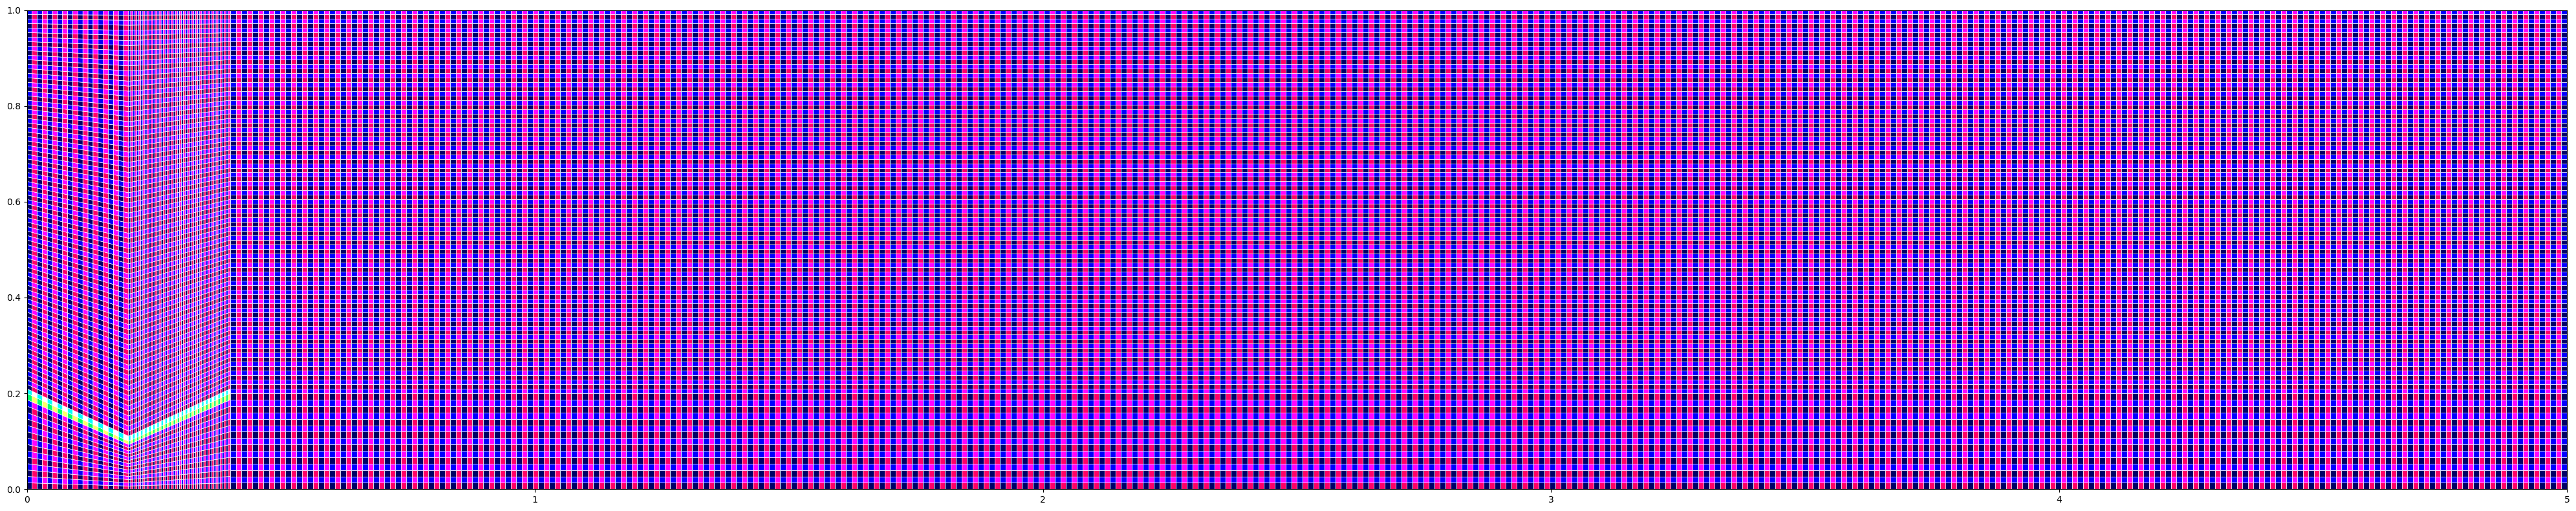

./20220609\x=400y=200Pr=0.012-c.cas.geo
[5.        0.0133333 0.       ]
[4.98918   0.0133333 0.       ]
[4.98918 0.      0.     ]
[5. 0. 0.]
boxes: (49500, 4, 2)
(495, 100, 3)


KeyboardInterrupt: 

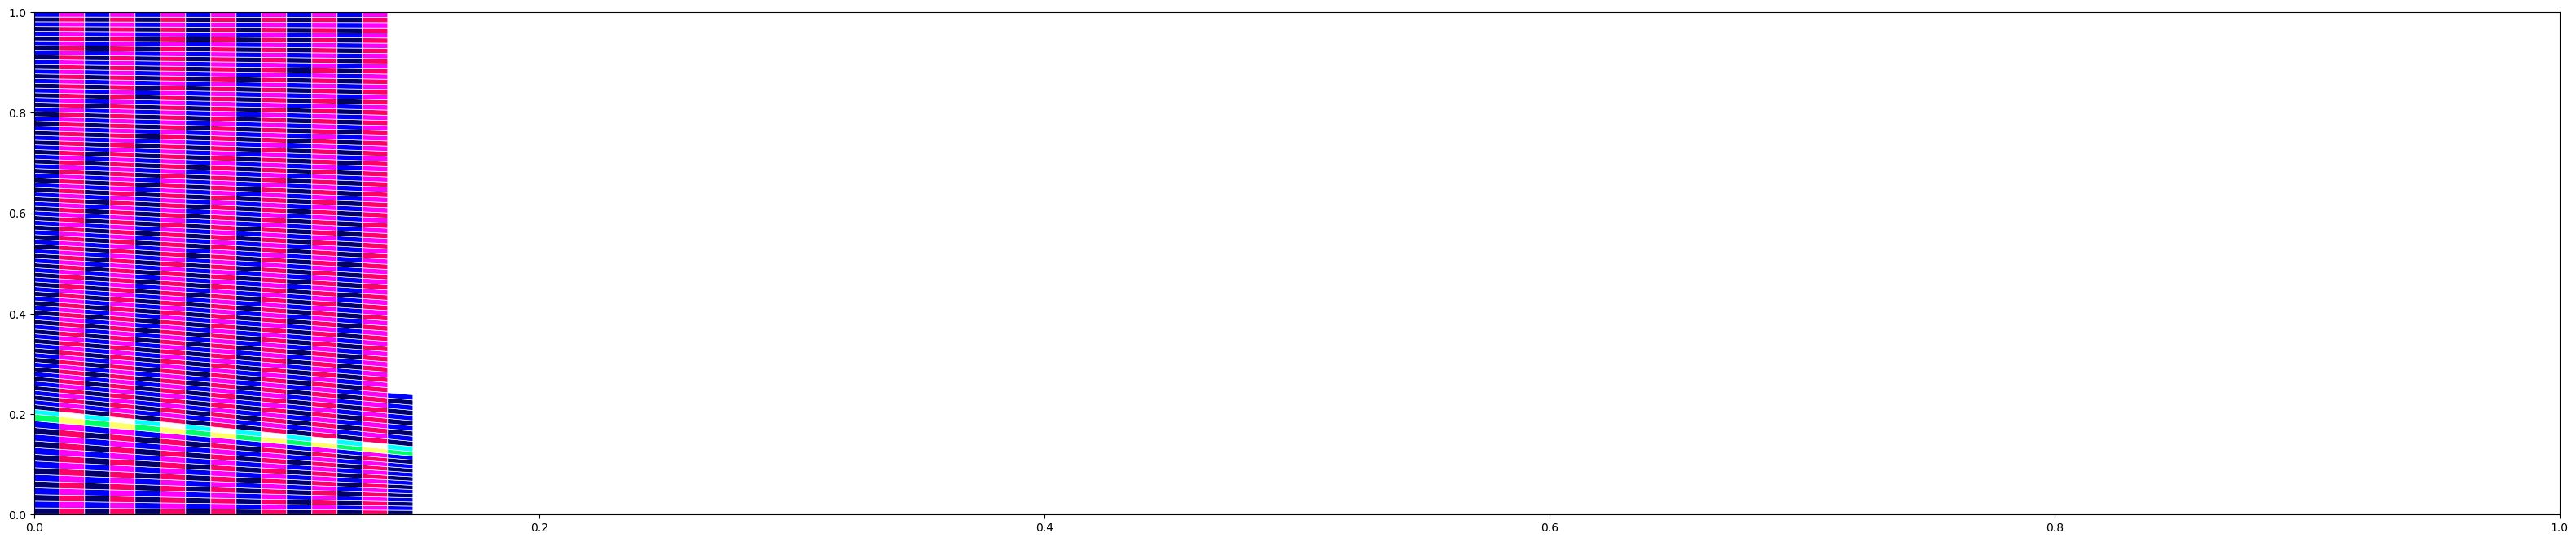

In [13]:
def draw_mesh(coordinates, cells, colors: np.ndarray = np.array([])):
    fig = plt.figure(num=1, clear=True, figsize=[40, 8])
    ax = plt.subplot(1, 1, 1)

    for i in range(cells.shape[0]):
        color = "b"
        if np.size(colors) != 0:
            assert colors.shape[0] == cells.shape[0]
            color = colors[i]
        triangle = coordinates[cells[i]-1, :2]
        poly = Polygon(triangle, lw=0.5, edgecolor='w', facecolor=color, zorder=0)
        ax.add_patch(poly)
    plt.tight_layout()
    plt.xlim([0.0, 5.0])
    plt.ylim([0.0, 1.0])
    #plt.savefig("./refine_area/"+file+"_fig.png")
    
    
    plt.show()
    plt.figure(num=1, clear=True)
    plt.close()








train_data_path = "./train_data/"

if not os.path.exists(train_data_path):
    os.mkdir(train_data_path)

raw_prefix = "./20220609/"

file_names = glob.glob(raw_prefix+"*.cas.geo")
total_lines = []
for file_name in file_names:
    file_name_lower = file_name.lower()
    file_name_lower = file_name_lower[len(raw_prefix):]

    # 파일 제목으로부터 x, y, z 읽어오기
    data_x = float(file_name_lower.split("y")[0].split("=")[1]) / 1000.0
    data_y = float(file_name_lower.split("y")[1].split("pr")[0].split("=")[1]) / 1000.0
    data_pr = float(file_name_lower.split("y")[1].split("pr")[1].split("-")[0].split("=")[1])


    print("="*25)
    print(file_name)
    print("="*25)

    # 지오메트리 파일로 부터 라인 읽기
    with open(file_name, "r") as f:
        lines = f.readlines()
    # 노드 개수 읽기 (9번째 줄)
    node_n = int(lines[8])

    # 노드 좌표 변수 준비
    coordinate = np.zeros([node_n, 3])

    # 노드 좌표 읽기
    # 첫번째 node_n개 : x 좌표
    # 두번째 node_n개 : y 좌표
    # 세번째 node_n개 : z 좌표
    for i in range(node_n):
        coordinate[i, 0] = float(lines[9+i])
        coordinate[i, 1] = float(lines[9+node_n+i])
        coordinate[i, 2] = float(lines[9+node_n*2+i])
    print(coordinate[0])
    print(coordinate[1])
    print(coordinate[2])
    print(coordinate[3])
    # cell 개수 읽기
    # 9+node_n*3   = cell 집합 이름
    # 9+node_n*3+1 = cell 집합 내 cell 개수
    cell_n = int(lines[9+node_n*3+1])

    # cell 변수 준비
    # 사각형 cell을 이루는 노드 좌표의 index 4개
    cells = np.zeros([cell_n, 4], dtype=int)

    # index 좌표 읽기
    # 각 줄마다 cell 하나. 예:
    # 1 2 3 4
    for i in range(cell_n):
        coor_idx = lines[9 + node_n*3+2 + i].split()
        for j in range(4):
            cells[i, j] = int(coor_idx[j])

    # 압력 그래디언트 파일 읽기
    with open(file_name[:-3]+"scl1", "r") as f:
        lines = f.readlines()

    # 압력 (그래디언트) 변수 준비. 각 셀마다 존재
    pr_grad = np.zeros([cell_n])

    # 압력 읽기 (index: 4 ~ )
    for i in range(cell_n):
        pr_grad[i] = float(lines[4+i])
        triangle = coordinate[cells[i]-1, :2]
        if np.mean(triangle[:, 0]) < 0.2:
            pr_grad[i] = 0
    pr_grad_sorted = np.sort(pr_grad)
    pr_grad_thres = pr_grad_sorted[int(pr_grad.shape[0]*0.95)]

    
    # cells_xy: (cell_n, 2). 각 cell의 중심점. 정렬을 위해 사용
    boxes = coordinate[cells-1, :2]
    print("boxes:", boxes.shape)
    cells_xy = np.mean(boxes, axis=1)

    # x 좌표에 따라 정렬시 x 오차에 의하여 다른 행처럼 정렬되는 것을 방지함.
    # 제안: 더 효율적인 정렬 방법으로 바꿀 수 있음
    #       x 축으로 정렬 -> 100개 단위로 y축 정렬을 수행함.
    keys = []
    for i in range(cells_xy.shape[0]):
        is_matched = False
        for k in keys:
            if abs(cells_xy[i, 0] - k) < 0.00001:
                is_matched = True
                cells_xy[i, 0] = k
        if not is_matched:
            keys.append(cells_xy[i, 0])


    # idx1: y 좌표로 박스들을 정렬하는 인덱스
    # idx2: y 좌표로 박스들을 정렬한 후 x 좌표로 박스들을 정렬하는 인덱스
    #       기존 순서를 유지하는 정렬을 반드시 사용하여 idx1의 순서를 해치지 않도록 함.
    
    idx1 = np.argsort(cells_xy[:, 1])
    sorted_cell_xy = cells_xy[idx1]
    idx2 = np.argsort(sorted_cell_xy[:, 0], kind="mergesort")

    # cells, pr을 위의 기준으로 정렬함.
    # 기대하는 바: cell의 순서가 [(0, 0), (0, 0.1), ..., (0, 1.0), (0.1, 0.0), ...]이런 식으로
    #             사전순으로 정렬되기를 바람
    cells = cells[idx1][idx2]
    pr_grad = pr_grad[idx1][idx2]

    # mesh 그림 그리기 위한 cell마다의 색깔 행렬
    colors = np.zeros([cells.shape[0], 3])
    #colors[:, 2] = 1.0    

    #colors : (495, 100, 3) = (n_width, n_height, 3)
    colors = colors.reshape([-1, 100, 3])

    colors[:70, 14:16, 1] = 1.0
    print(colors.shape)
    colors = colors.reshape([-1, 3])

    # 특징 생성 및 저장
    for i in range(cells.shape[0]):
        colors[i, 0] = ((i) // 100) % 2
        colors[i, 2] = 0.4 + 0.6*(i % 2)
        
    #total_lines += processed_lines
    #np.savetxt(train_data_path+low_file+".csv", processed_lines, "%.8f", delimiter=',')
    draw_mesh(coordinate, cells, colors)
    assert False
#np.savetxt(train_data_path+"feature_data_for_each_element.csv", total_lines, "%.8f", delimiter = ',')


## 바이너리 특징을 포함한 학습 데이터 만들기

- 다음 코드는 Cell의 위치를 정렬한다 (CNN에 쓰기 편함)
- 다음 코드는 (노즐 내부/외부 등의) 바이너리 정보를 포함한다.
- 노즐 5각형에 대한 MVC 특징은 나중에 실제 사용할 때 제거할 것을 추천. 과거 코드이므로 남겨둠

./20220609\x=400y=200Pr=0.007-c.cas.geo
[5.        0.0133333 0.       ]
[4.98918   0.0133333 0.       ]
[4.98918 0.      0.     ]
[5. 0. 0.]
(49500, 4)
(49500, 4, 2)
(49500, 2)
(495, 100, 3)


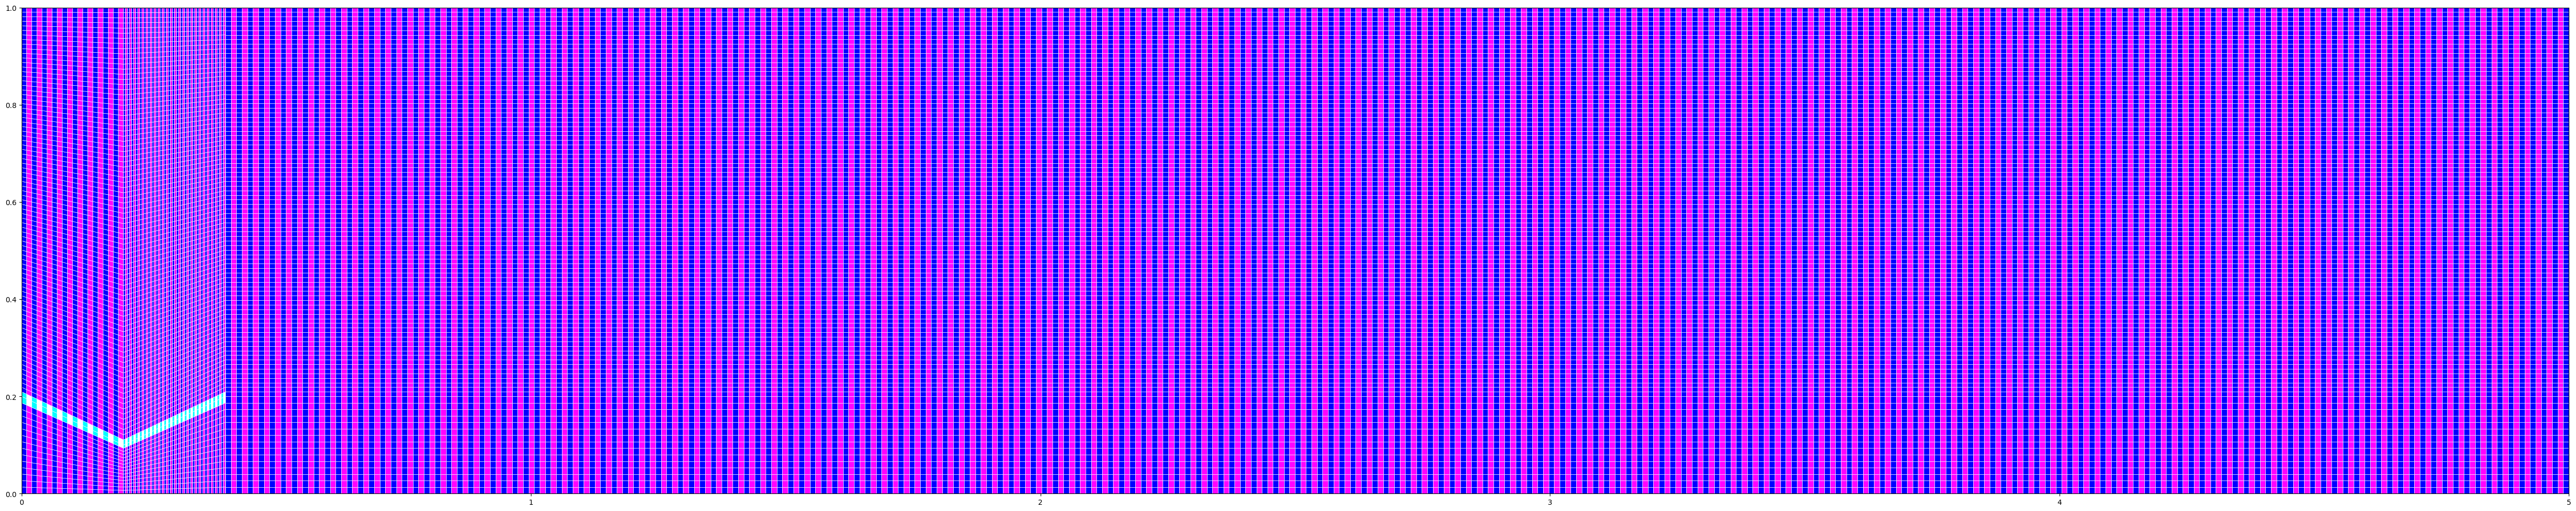

AssertionError: 

In [10]:
test_data_path = "./train_data/"

if not os.path.exists(test_data_path):
    os.mkdir(train_data_path)

raw_prefix = "./20220609/"

file_names = glob.glob(raw_prefix+"*.cas.geo")
total_lines = []
for file_name in file_names:
    file_name_lower = file_name.lower()
    file_name_lower = file_name_lower[len(raw_prefix):]

    # 파일 제목으로부터 x, y, z 읽어오기
    data_x = float(file_name_lower.split("y")[0].split("=")[1]) / 1000.0
    data_y = float(file_name_lower.split("y")[1].split("pr")[0].split("=")[1]) / 1000.0
    data_Pr = float(file_name_lower.split("y")[1].split("pr")[1].split("-")[0].split("=")[1])

    print("="*25)
    print(file_name)
    print("="*25)

    # 지오메트리 파일로 부터 라인 읽기
    with open(file_name, "r") as f:
        lines = f.readlines()
    # 노드 개수 읽기 (9번째 줄)
    node_n = int(lines[8])

    # 노드 좌표 변수 준비
    coordinate = np.zeros([node_n, 3])

    # 노드 좌표 읽기
    # 첫번째 node_n개 : x 좌표
    # 두번째 node_n개 : y 좌표
    # 세번째 node_n개 : z 좌표
    for i in range(node_n):
        coordinate[i, 0] = float(lines[9+i])
        coordinate[i, 1] = float(lines[9+node_n+i])
        coordinate[i, 2] = float(lines[9+node_n*2+i])
    # cell 개수 읽기
    # 9+node_n*3   = cell 집합 이름
    # 9+node_n*3+1 = cell 집합 내 cell 개수
    cell_n = int(lines[9+node_n*3+1])

    # cell 변수 준비
    # 사각형 cell을 이루는 노드 좌표의 index 4개
    cells = np.zeros([cell_n, 4], dtype=int)

    # index 좌표 읽기
    # 각 줄마다 cell 하나. 예:
    # 1 2 3 4
    for i in range(cell_n):
        coor_idx = lines[9 + node_n*3+2 + i].split()
        for j in range(4):
            cells[i, j] = int(coor_idx[j])

    # 압력 그래디언트 파일 읽기
    with open(file_name[:-3]+"scl1", "r") as f:
        lines = f.readlines()

    # 압력 (그래디언트) 변수 준비. 각 셀마다 존재
    pr_grad = np.zeros([cell_n])

    # 압력 읽기 (index: 4 ~ )
    for i in range(cell_n):
        pr_grad[i] = float(lines[4+i])
        triangle = coordinate[cells[i]-1, :2]
        if np.mean(triangle[:, 0]) < 0.2:
            pr_grad[i] = 0
    pr_grad_sorted = np.sort(pr_grad.copy())
    pr_grad_thres = pr_grad_sorted[int(pr_grad.shape[0]*0.95)]

    # 메시 그림용 코드
    colors = np.zeros([cells.shape[0], 3])
    colors[:, 2] = 1.0
    

    #colors[pr_grad > pr_grad_threshold, 0] = 1.0

    # cells_xy: (cell_n, 2). 각 cell의 중심점. 정렬을 위해 사용
    cells_xy = np.zeros([cells.shape[0], 2])
    boxs = coordinate[cells-1, :2]
    cells_xy = np.mean(boxs, axis=1)

    # x 좌표에 따라 정렬시 x 오차에 의하여 다른 행처럼 정렬되는 것을 방지함.
    # 제안: 더 효율적인 정렬 방법으로 바꿀 수 있음
    #       x 축으로 정렬 -> 100개 단위로 y축 정렬을 수행함.
    keys = []
    for i in range(cells_xy.shape[0]):
        is_matched = False
        for k in keys:
            if abs(cells_xy[i, 0] - k) < 0.00001:
                is_matched = True
                cells_xy[i, 0] = k
        if not is_matched:
            keys.append(cells_xy[i, 0])

    print(cells_xy.shape)

    # idx1: y 좌표로 박스들을 정렬하는 인덱스
    # idx2: y 좌표로 박스들을 정렬한 후 x 좌표로 박스들을 정렬하는 인덱스
    #       기존 순서를 유지하는 정렬을 반드시 사용하여 idx1의 순서를 해치지 않도록 함.
    idx1 = np.argsort(cells_xy[:, 1])
    sorted_cell_xy = cells_xy[idx1]
    idx2 = np.argsort(sorted_cell_xy[:, 0], kind="mergesort")
    #sorted_cell_xy = sorted_cell_xy[idx2]

    # 정렬 적용
    cells = cells[idx1][idx2]
    pr_grad = pr_grad[idx1][idx2]


    # binary 데이터 만들기
    bi_data = np.zeros([cells.shape[0]])
    in_nozzle = bi_data.copy().reshape([-1, 100])
    left_end = bi_data.copy().reshape([-1, 100])
    right_end = bi_data.copy().reshape([-1, 100])
    down_end = bi_data.copy().reshape([-1, 100])
    up_end = bi_data.copy().reshape([-1, 100])
    nozzle_wall = bi_data.copy().reshape([-1, 100])

    # 노즐 내부에 있다면 1
    in_nozzle[:70, :15] = 1.0
    # 메시 왼쪽 끝에 붙어있다면 1
    left_end[0] = 1.0
    # 메시 오른쪽 끝에 붙어있다면 1
    right_end[-1] = 1.0
    # 메시 아래 끝에 붙어있다면 1
    down_end[:, 0] = 1.0
    # 메시 위 끝에 붙어있다면 1
    up_end[:, -1] = 1.0
    # 노즐 벽에 붙어있다면 1
    nozzle_wall[:70, 14:16] = 1.0

    in_nozzle = in_nozzle.reshape([-1])
    left_end = left_end.reshape([-1])
    right_end = right_end.reshape([-1])
    down_end = down_end.reshape([-1])
    up_end = up_end.reshape([-1])
    nozzle_wall = nozzle_wall.reshape([-1])

    # 처리된 데이터를 위한 변수
    processed_lines = []

    # 특징 생성 및 저장
    for i in range(cells.shape[0]):

        line = []

        triangle = coordinate[cells[i]-1, :2]
        # 데이터의 정보를 특징으로
        line.append(data_x)
        line.append(data_y)
        line.append(data_Pr)

        # 노즐의 각도 (라디안)
        line.append(np.arctan((data_y-0.1)/(data_x-0.2)))

        x0 = np.mean(triangle[:, 0])
        y0 = np.mean(triangle[:, 1])
        # cell의 중심을 틍징으로
        line.append(x0)
        line.append(y0)
        # mesh를 이루는 4각형의 MVC
        line.append(weight([x0, y0], [0, 0], [0, 1], [5, 1]))
        line.append(weight([x0, y0], [0, 1], [5, 1], [5, 0]))
        line.append(weight([x0, y0], [5, 1], [5, 0], [0, 0]))
        line.append(weight([x0, y0], [5, 0], [0, 0], [0, 1]))
        #[[0, 0], [0, 0.2], [0.2, 0.1], [0.4, 0.2], [0.4, 0.0]]

        # 노즐을 이루는 5각형의 MVC
        line.append(weight([x0, y0], [0.0, 0.0], [0.0, data_y], [0.2, 0.1]))
        line.append(weight([x0, y0], [0.0, data_y], [0.2, 0.1], [data_x, data_y]))
        line.append(weight([x0, y0], [0.2, 0.1], [data_x, data_y], [data_x, 0.0]))
        line.append(weight([x0, y0], [data_x, data_y], [data_x, 0.0], [0.0, 0.0]))
        line.append(weight([x0, y0], [data_x, 0.0], [0.0, 0.0], [0.0, data_y]))

        # 바이너리 데이터 추가
        line.append(in_nozzle[i])
        line.append(left_end[i])
        line.append(right_end[i])
        line.append(down_end[i])
        line.append(up_end[i])
        line.append(nozzle_wall[i])

        # 상위 5%라면 label=1, 아니라면 label=0
        if pr_grad[i] > pr_grad_thres:
            colors[i, 0] = 1.0 
            line.append(1.0)
        else:
            line.append(0.0)
        processed_lines.append(line)
    total_lines += processed_lines
    
    #draw_mesh(coordinate, cells, colors)
    
    np.savetxt(train_data_path+file_name_lower+"_plus_bi.csv", processed_lines, "%.8f", delimiter=',')
np.savetxt(train_data_path+"feature_data_for_each_element_plus_bi.csv", total_lines, "%.8f", delimiter = ',')

# Test Data 생성 (정렬, 바이너리특징 사용)

In [14]:
test_data_path = "./test_data/"

if not os.path.exists(test_data_path):
    os.mkdir(test_data_path)



raw_prefix = "./20210812/"

# 테스트 데이터 중에서 해당 파일들만 사용함. 
# 큰 이유는 없고... 당시에 전달하기로 미리 이야기된 18개의 파일
# files = glob.glob(raw_prefix+"*.cas.geo")
file_names = [
    raw_prefix + "x=400y=200Pr=0.01-c.cas.geo", 
    raw_prefix + "x=400y=244.9489743Pr=0.016-c.cas.geo",
    raw_prefix +"x=400y=282.8427125Pr=0.2-c.cas.geo",
    raw_prefix +"x=500y=200Pr=0.01-c.cas.geo",
    raw_prefix +"x=500y=244.9489743Pr=0.016-c.cas.geo",
    raw_prefix +"x=500y=282.8427125Pr=0.2-c.cas.geo",
    raw_prefix +"x=600y=200Pr=0.01-c.cas.geo",
    raw_prefix +"x=600y=244.9489743Pr=0.016-c.cas.geo",
    raw_prefix +"x=600y=282.8427125Pr=0.2-c.cas.geo",
    raw_prefix +"x=700y=200Pr=0.01-c.cas.geo",
    raw_prefix +"x=700y=244.9489743Pr=0.016-c.cas.geo",
    raw_prefix +"x=700y=282.8427125Pr=0.2-c.cas.geo",
    raw_prefix +"x=800y=200Pr=0.01-c.cas.geo",
    raw_prefix +"x=800y=244.9489743Pr=0.016-c.cas.geo",
    raw_prefix +"x=800y=282.8427125Pr=0.2-c.cas.geo",
    raw_prefix +"x=900y=200Pr=0.01-c.cas.geo",
    raw_prefix +"x=900y=244.9489743Pr=0.016-c.cas.geo",
    raw_prefix +"x=900y=282.8427125Pr=0.2-c.cas.geo",
]
total_lines = []
for file_name in file_names:
    file_name_lower = file_name.lower()
    file_name_lower = file_name_lower[len(raw_prefix):]

    # 파일 제목으로부터 x, y, z 읽어오기
    data_x = float(file_name_lower.split("y")[0].split("=")[1]) / 1000.0
    data_y = float(file_name_lower.split("y")[1].split("pr")[0].split("=")[1]) / 1000.0
    data_Pr = float(file_name_lower.split("y")[1].split("pr")[1].split("-")[0].split("=")[1])
    #if abs(data_Pr - 0.007) > 0.0001:
    #    continue
    #print(data_x)
    #print(data_y)
    #print(data_Pr)

    print("="*25)
    print(file_name)
    print("="*25)

    # 지오메트리 파일로 부터 라인 읽기
    with open(file_name, "r") as f:
        lines = f.readlines()
    # 노드 개수 읽기 (9번째 줄)
    node_n = int(lines[8])

    # 노드 좌표 변수 준비
    coordinate = np.zeros([node_n, 3])

    # 노드 좌표 읽기
    # 첫번째 node_n개 : x 좌표
    # 두번째 node_n개 : y 좌표
    # 세번째 node_n개 : z 좌표
    for i in range(node_n):
        coordinate[i, 0] = float(lines[9+i])
        coordinate[i, 1] = float(lines[9+node_n+i])
        coordinate[i, 2] = float(lines[9+node_n*2+i])
    # cell 개수 읽기
    # 9+node_n*3   = cell 집합 이름
    # 9+node_n*3+1 = cell 집합 내 cell 개수
    cell_n = int(lines[9+node_n*3+1])

    # cell 변수 준비
    # 사각형 cell을 이루는 노드 좌표의 index 4개
    cells = np.zeros([cell_n, 4], dtype=int)

    # index 좌표 읽기
    # 각 줄마다 cell 하나. 예:
    # 1 2 3 4
    for i in range(cell_n):
        coor_idx = lines[9 + node_n*3+2 + i].split()
        for j in range(4):
            cells[i, j] = int(coor_idx[j])

    # 압력 그래디언트 파일 읽기
    with open(file_name[:-3]+"scl1", "r") as f:
        lines = f.readlines()

    # 압력 (그래디언트) 변수 준비. 각 셀마다 존재
    pr_grad = np.zeros([cell_n])

    # 압력 읽기 (index: 4 ~ )
    for i in range(cell_n):
        pr_grad[i] = float(lines[4+i])
        triangle = coordinate[cells[i]-1, :2]
        if np.mean(triangle[:, 0]) < 0.2:
            pr_grad[i] = 0
    pr_grad_sorted = np.sort(pr_grad.copy())
    pr_grad_thres = pr_grad_sorted[int(pr_grad.shape[0]*0.95)]

    colors = np.zeros([cells.shape[0], 3])
    colors[:, 2] = 1.0
    

    #colors[pressure > pressure_threshold, 0] = 1.0
    
    
    #assert False
    print(cells.shape)


    cells_xy = np.zeros([cells.shape[0], 2])

    boxs = coordinate[cells-1, :2]
    print(boxs.shape)
    #assert False
    cells_xy = np.mean(boxs, axis=1)

    keys = []
    for i in range(cells_xy.shape[0]):
        is_matched = False
        for k in keys:
            if abs(cells_xy[i, 0] - k) < 0.00001:
                is_matched = True
                cells_xy[i, 0] = k
        if not is_matched:
            keys.append(cells_xy[i, 0])

    print(cells_xy.shape)

    idx1 = np.argsort(cells_xy[:, 1])
    sorted_cell_xy = cells_xy[idx1]
    idx2 = np.argsort(sorted_cell_xy[:, 0], kind="mergesort")
    #sorted_cell_xy = sorted_cell_xy[idx2]

    cells = cells[idx1][idx2]
    pr_grad = pr_grad[idx1][idx2]

    #for i in range(cells.shape[0]):
    #    box = coordinate[cells[i]-1, :2]
    #    print(np.mean(box, axis=0))

    # binary 데이터 만들기
    bi_data = np.zeros([cells.shape[0]])
    in_nozzle = bi_data.copy().reshape([-1, 100])
    left_end = bi_data.copy().reshape([-1, 100])
    right_end = bi_data.copy().reshape([-1, 100])
    down_end = bi_data.copy().reshape([-1, 100])
    up_end = bi_data.copy().reshape([-1, 100])
    nozzle_wall = bi_data.copy().reshape([-1, 100])

    in_nozzle[:70, :15] = 1.0
    left_end[0] = 1.0
    right_end[-1] = 1.0
    down_end[:, 0] = 1.0
    up_end[:, -1] = 1.0
    nozzle_wall[:70, 14:16] = 1.0

    in_nozzle = in_nozzle.reshape([-1])
    left_end = left_end.reshape([-1])
    right_end = right_end.reshape([-1])
    down_end = down_end.reshape([-1])
    up_end = up_end.reshape([-1])
    nozzle_wall = nozzle_wall.reshape([-1])

    # 처리된 데이터를 위한 변수
    processed_lines = []

    # 특징 생성 및 저장
    for i in range(cells.shape[0]):

        line = []

        triangle = coordinate[cells[i]-1, :2]
        # 데이터의 정보를 특징으로
        line.append(data_x)
        line.append(data_y)
        line.append(data_Pr)

        # 노즐의 각도 (라디안)
        line.append(np.arctan((data_y-0.1)/(data_x-0.2)))

        x0 = np.mean(triangle[:, 0])
        y0 = np.mean(triangle[:, 1])
        # cell의 중심을 틍징으로
        line.append(x0)
        line.append(y0)
        # mesh를 이루는 4각형의 MVC
        line.append(weight([x0, y0], [0, 0], [0, 1], [5, 1]))
        line.append(weight([x0, y0], [0, 1], [5, 1], [5, 0]))
        line.append(weight([x0, y0], [5, 1], [5, 0], [0, 0]))
        line.append(weight([x0, y0], [5, 0], [0, 0], [0, 1]))
        #[[0, 0], [0, 0.2], [0.2, 0.1], [0.4, 0.2], [0.4, 0.0]]

        # 노즐을 이루는 5각형의 MVC
        line.append(weight([x0, y0], [0.0, 0.0], [0.0, data_y], [0.2, 0.1]))
        line.append(weight([x0, y0], [0.0, data_y], [0.2, 0.1], [data_x, data_y]))
        line.append(weight([x0, y0], [0.2, 0.1], [data_x, data_y], [data_x, 0.0]))
        line.append(weight([x0, y0], [data_x, data_y], [data_x, 0.0], [0.0, 0.0]))
        line.append(weight([x0, y0], [data_x, 0.0], [0.0, 0.0], [0.0, data_y]))

        # 바이너리 데이터 추가
        line.append(in_nozzle[i])
        line.append(left_end[i])
        line.append(right_end[i])
        line.append(down_end[i])
        line.append(up_end[i])
        line.append(nozzle_wall[i])

        # 상위 5%라면 1, 아니라면 0
        if pr_grad[i] > pr_grad_thres:
            colors[i, 0] = 1.0 
            line.append(1.0)
        else:
            line.append(0.0)
        #cell을 이루는 4각좌표
        line.append(triangle[0, 0])
        line.append(triangle[0, 1])
        line.append(triangle[1, 0])
        line.append(triangle[1, 1])
        line.append(triangle[2, 0])
        line.append(triangle[2, 1])
        line.append(triangle[3, 0])
        line.append(triangle[3, 1])
        
        processed_lines.append(line)
        
    total_lines += processed_lines
    
    #draw_mesh(coordinate, cells, colors)
    
    np.savetxt(test_data_path+file_name_lower+"_plus_bi.csv", processed_lines, "%.8f", delimiter=',')
np.savetxt(test_data_path+"feature_data_for_each_element_plus_bi.csv", total_lines, "%.8f", delimiter = ',')

./20210812/x=400y=200Pr=0.01-c.cas.geo
(49500, 4)
(49500, 4, 2)


KeyboardInterrupt: 

## 데이터 차원 바꾸기

In [ ]:
train_data_path = "train_data/"
total_data = []

for file_name in glob.glob(train_data_path+"x*_plus_bi.csv"):
  print(file_name)
  with open(file_name, "r") as file:
    data = np.loadtxt(file, delimiter=",")
  #print(data.shape)
  data = data.reshape([495, 100, -1])
  total_data.append(data)
  

total_data = np.array(total_data)
print(total_data.shape)

with open(train_data_path +"images_data.npy", "wb") as f:
    np.save(f, total_data)
    
#with open("images_data.npy", "wb") as f:
#    np.save(f, total_data)


## 정규화 및 "노즐 5각형 MVC 특징" 제거

In [ ]:
# 학습 데이터
with open("./train_data/images_data.npy", "rb") as f:
    total_data = np.load(f)
features = list(range(9)) + list(range(15,22))
total_data = total_data[:, :, :, features]

total_data_mean = np.mean(total_data, axis=(0,1,2), keepdims=True)
total_data_std = np.std(total_data, axis=(0,1,2), keepdims=True)
print(total_data_mean.shape)
print(total_data_std.shape)

total_data[:,:,:,:-1] = (total_data[:,:,:,:-1] - total_data_mean[:,:,:,:-1]) / total_data_std[:,:,:,:-1]

#print(np.any(np.isnan(total_data)))

with open("norm_images_data_dim_16.npy", "wb") as f:
    np.save(f, total_data)

# 테스트 데이터
with open("test_data/images_data.npy", "rb") as f:
    test_data = np.load(f)
features = list(range(9)) + list(range(15,22))
test_data = test_data[:, :, :, features]

test_data[:,:,:,:-1] = (test_data[:,:,:,:-1] - total_data_mean[:,:,:,:-1]) / total_data_std[:,:,:,:-1]

print(test_data.shape)


#print(np.any(np.isnan(total_data)))

with open("test_norm_images_data_dim_16.npy", "wb") as f:
    np.save(f, test_data)
